In [152]:
#import some stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import glob
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split #use this?
from scipy import stats
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

In [2]:
urlScout = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv'
urlWomen = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_womens.csv'
dataScout = pd.read_csv(urlScout)
dataWomen = pd.read_csv(urlWomen)

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
dataScout.head(1)

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,Sudbury Wolves,Blake Murray,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN


In [6]:
#dataWomen.head(1)

In [259]:
def fixDumpsX(row):
    if row['Event'] == 'Dump In/Out':
        if row['NextEvent'] == 'Puck Recovery':
            if row['NextX'] < 75:
                return (200 - row['NextX'])
            else:
                return row['NextX']
        else:
            if row['NextXShift2'] < 75:
                return (200 - row['NextXShift2'])
            else:
                return row['NextXShift2']
    else:
        return row['X Coordinate 2']
    
def fixDumpsY(row):
    if row['Event'] == 'Dump In/Out':
        if row['NextEvent'] == 'Puck Recovery':
            if row['NextX'] < 75:
                return (85 - row['NextY'])
            else:
                return row['NextY']
        else:
            if row['NextXShift2'] < 75:
                return (85 - row['NextYShift2'])
            else:
                return row['NextYShift2']
    else:
        return row['Y Coordinate 2']

def getDataReady(df):
    df = df.copy()
    df['NextEvent'] = df['Event'].shift(-1)
    df['NextEvent2'] = df['Event'].shift(-2)
    df['NextX'] = df['X Coordinate'].shift(-1)
    df['NextY'] = df['Y Coordinate'].shift(-1)
    df['NextXShift2'] = df['X Coordinate'].shift(-2)
    df['NextYShift2'] = df['Y Coordinate'].shift(-2)
    #filter out dumps that go to goalie
    df = df.loc[((df['Event'] == 'Dump In/Out') & ((df['NextEvent'] == 'Puck Recovery') | (df['NextEvent2'] == 'Puck Recovery'))) | (df['Event'] != 'Dump In/Out')]
    df['X Coordinate 2'] = df.apply(lambda row: fixDumpsX(row),axis=1)
    df['Y Coordinate 2'] = df.apply(lambda row: fixDumpsY(row),axis=1)
    df['isDump'] = df.apply(lambda row: 1 if (row['Event'] == 'Dump In/Out') else 0,axis=1)
    df['isDumpRetained'] = df.apply(lambda row: (row['Detail 1'] == 'Retained'),axis=1)
    
    filteredDF = df.loc[(df['Event'] ==  'Play' ) | (df['Event'] == 'Incomplete Play') | (df['Event'] == 'Dump In/Out')].copy() #only need these rows
    filteredDF['TeamSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Home Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['OppSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Away Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['onPP'] = filteredDF.apply(lambda row: 1*((row['TeamSkaters'] > row['OppSkaters']) & (row['OppSkaters'] < 5)),axis=1)
    filteredDF['onPK'] = filteredDF.apply(lambda row: 1*((row['TeamSkaters'] < row['OppSkaters']) & (row['TeamSkaters'] < 5)),axis=1)
    filteredDF['AmountExtraSkaters'] = filteredDF.apply(lambda row: row['TeamSkaters'] - row['OppSkaters'],axis=1)
    filteredDF['CompletePass'] = filteredDF.apply(lambda row: 1 if (row['Event'] == 'Play') else 0,axis=1)
    filteredDF['CompletePass'] = filteredDF.apply(lambda row: 1 if ((row['isDump'] == 1) & row['isDumpRetained'])
                                                  else row['CompletePass'],axis=1)
    filteredDF['passXTravel'] = filteredDF.apply(lambda row: row['X Coordinate 2'] - row['X Coordinate'],axis=1)
    filteredDF['passYTravel'] = filteredDF.apply(lambda row: row['Y Coordinate 2'] - row['Y Coordinate'],axis=1)
    filteredDF['TotalDistance'] = filteredDF.apply(lambda row: (row['passXTravel']**2 + row['passYTravel']**2)**0.5,axis=1)
    filteredDF['isPassOrDump'] = filteredDF.apply(lambda row: 1,axis=1)
    
    #this is important for when I'm only using 1/25 the points to simplify the model
    filteredDF['X Coordinate 2'] = filteredDF.apply(lambda row: row['X Coordinate 2'] - (row['X Coordinate 2'] % 5),axis=1)
    filteredDF['Y Coordinate 2'] = filteredDF.apply(lambda row: row['Y Coordinate 2'] - (row['Y Coordinate 2'] % 5),axis=1)
    
    #this is for simple model
    #maybe only need first line + label?
    filteredDF = filteredDF[['X Coordinate','Y Coordinate','X Coordinate 2','Y Coordinate 2','onPP','onPK',
                             'isDump','passXTravel','passYTravel','TotalDistance','AmountExtraSkaters','isPassOrDump']]
    X = filteredDF.iloc[:,:-1]
    y = filteredDF.iloc[:,-1]
    return X,y

In [260]:
X,y = getDataReady(dataScout)

In [261]:
def getDist(x1,x2):
    return (x2-x1)
def get2dDist(xdist,ydist):
    return (xdist**2 + ydist**2)**0.5
def getAllCombos(df):
    df = df.copy()
    #df = df[0:1000] #this is just to make it smaller for testing
    tempList = []
    for i in range(len(df)):
        for x in range(26,40):
            x = x*5
            for y in range(17):
                y = y*5
                row = df.iloc[i]
                xdist = getDist(row['X Coordinate'],x)
                ydist = getDist(row['Y Coordinate'],y)
                tempList.append([row['X Coordinate'],row['Y Coordinate'],x,y,row['onPP'],row['onPK'],row['isDump'],
                                 xdist,ydist,get2dDist(xdist,ydist),row['AmountExtraSkaters'],0])
    tempDF = pd.DataFrame(tempList,columns=['X Coordinate','Y Coordinate','X Coordinate 2','Y Coordinate 2','onPP','onPK',
                                            'isDump','passXTravel','passYTravel','TotalDistance','AmountExtraSkaters','isPassOrDump'])
    
    return tempDF

In [262]:
%%time 
allcombos = getAllCombos(X)

Wall time: 2h 10min 58s


# Make the model

In [263]:
xAllCombos = allcombos.iloc[:,:-1]
yAllCombos = allcombos.iloc[:,-1]

In [264]:
concatX = pd.concat([xAllCombos,X])
concaty = pd.concat([yAllCombos,y])

In [269]:
Xaug = concatX.copy()
Xaug['Y Coordinate'] = Xaug.apply(lambda row: 85 - row['Y Coordinate'],axis=1)
Xaug['Y Coordinate 2'] = Xaug.apply(lambda row: 85 - row['Y Coordinate 2'],axis=1)

In [270]:
concatX2 = pd.concat([concatX,Xaug])
concaty2 = pd.concat([concaty,concaty])

In [273]:
#print("Overall Mean:", concaty.mean())
#get train/test split ready

Xtrain, Xtest, ytrain, ytest = train_test_split(concatX2,concaty2,test_size=0.25,random_state=8) #can add shuffle=False to not shuffle

In [274]:
print("train Mean:", ytrain.mean())
print("test Mean:", ytest.mean())


train Mean: 0.00419414118839876
test Mean: 0.004153978108443886


In [275]:
#train the xgboost model
dtrain = xgb.DMatrix(Xtrain,label=ytrain)

# XGBoost model
nrounds = 560 #use gridSearchCV
params = {
    'objective': 'binary:logistic',
    'booster' : 'gblinear', #gblinear/gbtree?
    'eval_metric' : ['logloss'],
    'eta' : 0.1,
    'gamma' : 3,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8,
    'max_depth': 6,
    'min_child_weight' : 6,
    'base_score' : ytrain.mean()
}

xcp_model = xgb.train(params, dtrain, num_boost_round=nrounds, verbose_eval=2)
# save for debug
xcp_model.save_model('xPassToPointNEWAug.json')

In [276]:
#test the model
dtest = xgb.DMatrix(Xtest,label=ytest)
xgb_predictions = xcp_model.predict(dtest).tolist()
print("XGBoost mean vs actual mean:")
# print(xgb_predictions)
XtestCopy = Xtest.copy()
XtestCopy['xPassToPoint'] = xgb_predictions
print(XtestCopy['xPassToPoint'].mean())
print(ytest.mean())

#now let's get the errors
#xGList = pd.concat([XtestxGCopy['xG'],ytestxG],axis=1,keys=['xG','Goal'])
#xGList = xGList.sort_values(by=['xG'])
LLerror = log_loss(ytest,xgb_predictions)
RMSerror = mean_squared_error(ytest,xgb_predictions,squared=False)
RMSLerror = mean_squared_log_error(ytest,xgb_predictions)
print("Log loss error is:",LLerror)
print("Root Mean Squared error is:",RMSerror)
print("Root Mean Squared Log error is:",RMSLerror)

XGBoost mean vs actual mean:
0.003941117108354328
0.004153978108443886
Log loss error is: 0.018164547790558958
Root Mean Squared error is: 0.054916255722872204
Root Mean Squared Log error is: 0.0014073674666141003


In [280]:
#test the model
dtest2 = xgb.DMatrix(concatX[0:100000])
xgb_predictions2 = xcp_model.predict(dtest2).tolist()
XtestCopy2 = concatX[0:100000].copy()
XtestCopy2['xPassToPoint'] = xgb_predictions2

# Look at results

In [281]:
testerdf = XtestCopy2.loc[(XtestCopy2['AmountExtraSkaters'] == 0) & (XtestCopy2['isDump'] == 0)].copy()

In [294]:
#choose some coordinates to look at 
testerdf2 = testerdf.loc[(testerdf['X Coordinate'] == 115)]
testerdf2 = testerdf2.loc[(testerdf2['Y Coordinate'] == 44)]

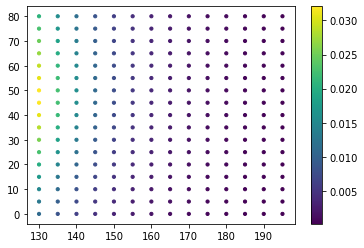

In [295]:
plt.figure()
plt.scatter(testerdf2['X Coordinate 2'].tolist(),testerdf2['Y Coordinate 2'].tolist(),c=testerdf2['xPassToPoint'].tolist(),s=10,cmap='viridis')
#plt.gray()
plt.colorbar()
plt.show()

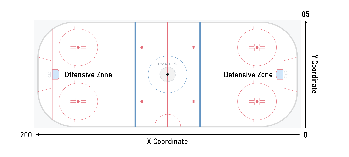

In [192]:
rinkPath = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/rink_coords.png'
im = plt.imread(rinkPath)
plt.imshow(im,extent=(0,210,0,90))
plt.axis('off')
plt.show()